# Step 1

* Load scalar, waveform and image h5 files.
* For each sweep, interpolate images on regular y grid. 
* For each y and image pixel, interpolate x-x'. (f(x, x', y, y3, x3))
* For each (x, xp, y, x3), interpolate yp. (f(x, x', y, y', x3))
* For each (x, xp, y, yp), inteprolate w. (f(x, x', y, y', w)).

In [1]:
import sys
import os
from os.path import join
import time
from datetime import datetime
import importlib
from pprint import pprint
import numpy as np
import pandas as pd
import h5py
import imageio
from scipy import ndimage
from scipy import interpolate
import skimage
from tqdm.notebook import tqdm
from tqdm.notebook import trange
from matplotlib import pyplot as plt
from matplotlib.patches import Ellipse
from plotly import graph_objects as go
import proplot as pplt
from ipywidgets import interactive

sys.path.append('../..')
from tools import energyVS06 as energy
from tools import image_processing as ip
from tools import plotting as mplt
from tools import utils

In [2]:
pplt.rc['grid'] = False
pplt.rc['cmap.discrete'] = False
pplt.rc['cmap.sequential'] = 'viridis'

## Setup

In [3]:
folder = '_output'

In [4]:
info = utils.load_pickle(join(folder, 'info.pkl'))
print('info')
pprint(info)

info
{'M': array([[1. , 0. , 0. ],
       [0. , 1. , 1.9],
       [0. , 0. , 1. ]]),
 'acts': ['y_PositionSync', 'xp_PositionSync', 'x_PositionSync'],
 'cam': 'cam34',
 'cam_pix2mm_x': 0.1,
 'cam_pix2mm_y': 0.1,
 'cam_shape': (512, 612),
 'cam_zoom': 0.5,
 'datadir': '/Diagnostics/Data/Measurements/scan-xxpy-image-ypdE/2022-04-29',
 'filename': '220429190854-scan-xxpy-image-ypdE',
 'image_crop_edges': {'x1': 190, 'x2': 460, 'y1': 135, 'y2': 435},
 'image_downscale': 4,
 'image_offset': 28.0,
 'image_pix2mm_x': 0.4,
 'image_pix2mm_y': 0.39705882352941174,
 'image_shape': (75, 68),
 'image_thresh': 98.0,
 'ndim': 3,
 'variables': {'x1': {'center': 21.0,
                      'distance': 17.5,
                      'max': 50.0,
                      'min': -50.0,
                      'pvname': 'ITSF_Diag:Slit_VT34a',
                      'steps': 32},
               'x2': {'center': 15.0,
                      'distance': 24.0,
                      'max': 50.0,
                      'm

In [5]:
datadir = info['datadir']
filename = info['filename']
datadir = info['datadir']
file = h5py.File(join(datadir, 'preproc-' + filename + '.h5'), 'r')
data_sc = file['/scalardata']
data_wf = file['/wfdata']
data_im = file['/imagedata']

print('Attributes:')
print()
for data in [data_sc, data_wf, data_im]:
    print(data.name)
    for item in data.dtype.fields.items():
        print(item)
    print()

Attributes:

/scalardata
('x_PositionSync', (dtype('<f8'), 0))
('xp_PositionSync', (dtype('<f8'), 8))
('y_PositionSync', (dtype('<f8'), 16))
('bcm04', (dtype('<f8'), 24))
('cam34_Integral', (dtype('<f8'), 32))
('cam34_Saturation', (dtype('<f8'), 40))
('iteration', (dtype('int64'), 48))
('timestamp', (dtype('<f8'), 56))

/wfdata
('cam34_ProfileX', (dtype(('<f4', (612,))), 0))
('cam34_ProfileY', (dtype(('<f4', (512,))), 2448))

/imagedata
('cam34_Image', (dtype(('<f8', (5100,))), 0))



In [7]:
variables = info['variables']
keys = list(variables)
ndim = len(keys)
center = np.array([variables[key]['center'] for key in keys])
distance = np.array([variables[key]['distance'] for key in keys])
nsteps = np.array([variables[key]['steps'] for key in keys])

M = info['M']
Minv = np.linalg.inv(M)

acts = info['acts']
points = np.vstack([data_sc[act] for act in acts]).T
points_n = utils.apply(Minv, points - center)
points_nn = points_n / (0.5 * distance)

# Interpolation

### Interpolate y 

Define a regular $y$ grid.

In [8]:
ygrid = np.linspace(np.min(points[:, 0]), np.max(points[:, 0]), int(nsteps[0]))

Interpolate the image stack along the $y$ axis on each iteration.

In [9]:
cam = info['cam']
image_shape = info['image_shape']
iterations = data_sc['iteration']
images = data_im[cam + '_Image'].reshape((points.shape[0], image_shape[0], image_shape[1]))

In [10]:
iteration_nums = np.unique(iterations)
n_iterations = len(iteration_nums)
images_3D = np.zeros((n_iterations, nsteps[0], image_shape[0], image_shape[1]))
for count, iteration in enumerate(tqdm(iteration_nums)):
    idx, = np.where(iterations == iteration)
    _points = points[idx, 0]
    _values = images[idx, :, :]
    fint = interpolate.interp1d(
        points[idx, 0],
        images[idx, :, :],
        axis=0,
        kind='linear', 
        bounds_error=False,
        fill_value=0.0, 
        assume_sorted=False,
    )
    images_3D[count, ...] = fint(ygrid) 

  0%|          | 0/1089 [00:00<?, ?it/s]

/home/46h/.venv/lib64/python3.9/site-packages/scipy/interpolate/_interpolate.py:641: RuntimeWarning: invalid value encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/home/46h/.venv/lib64/python3.9/site-packages/scipy/interpolate/_interpolate.py:641: RuntimeWarning: divide by zero encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]


In [11]:
def update(i, y):
    fig, ax = pplt.subplots()
    ax.imshow(images_3D[i, y, :, :])
    ax.format(xlabel='y3', ylabel='x3')
    plt.show()
    
interactive(update, i=(0, len(images_3D) - 1), y=(0, len(ygrid) - 1))

interactive(children=(IntSlider(value=544, description='i', max=1088), IntSlider(value=15, description='y', ma…

### Interpolate x-x'

Build the transfer matrices between the slits and the screen. (TO DO: Something needs to change sign for VS34 relative to VS06...)

In [12]:
a2mm = 1.009  # assume same for both dipoles
rho = 0.3556  # bend radius
GL05 = 0.0
GL06 = 0.0
l1 = 0.0
l2 = 0.0
l3 = 0.774
L2 = 0.311  # slit2 to dipole face
l = 0.129  # dipole face to VS06 screen (assume same for first/last dipole-screen)
LL = l1 + l2 + l3 + L2  # distance from emittance plane to dipole entrance
ecalc = energy.EnergyCalculate(l1=l1, l2=l2, l3=l3, L2=L2, l=l, amp2meter=a2mm*1e3)
Mslit = ecalc.getM1()  # slit-slit
Mscreen = ecalc.getM()  # slit-screen

Assume that $x_1$ and $x_2$ do not change on each iteration (or that the only variation is noise in the readback value). Select an $x$ and $x'$ for each $\left\{y, y_3, x_3\right\}$.

In [13]:
XXP = np.zeros((n_iterations, 2))
for iteration in iteration_nums:
    idx = iterations == iteration
    x2, x1 = np.mean(points[idx, 1:], axis=0)
    x = x1
    xp = 1e3 * ecalc.calculate_xp(x1 * 1e-3, x2 * 1e-3, Mslit)
    XXP[iteration - 1] = (x, xp)

Define the $x$-$x'$ interpolation grid. Tune `x_scale` and `xp_scale` to roughly align the grid points with the measured points.

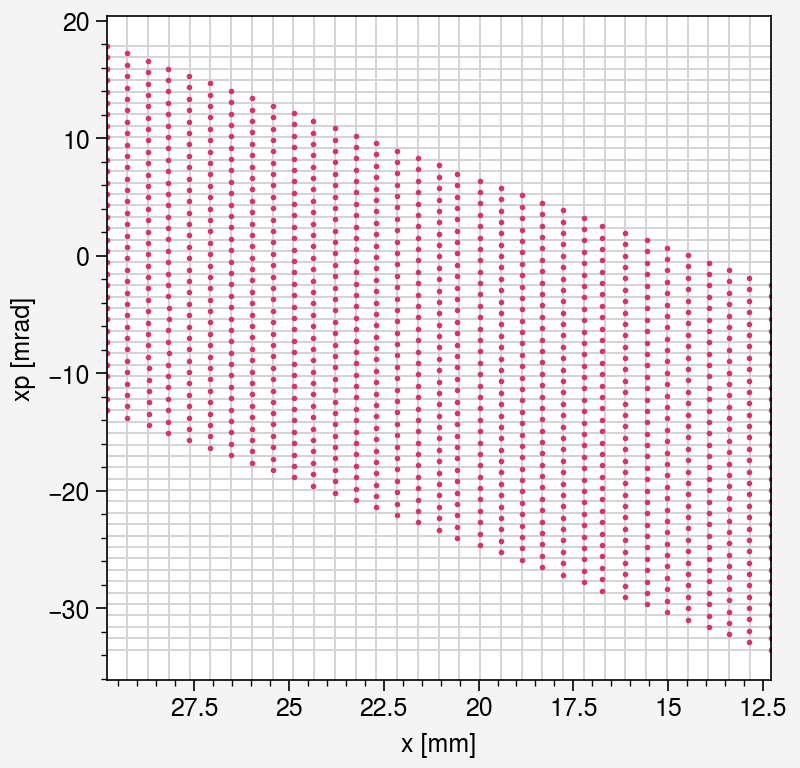

In [14]:
x_scale = 1.05
xp_scale = 1.7

x_min, xp_min = np.min(XXP, axis=0)
x_max, xp_max = np.max(XXP, axis=0)
xgrid = np.linspace(x_min, x_max, int(x_scale * nsteps[1]))
xpgrid = np.linspace(xp_min, xp_max, int(xp_scale * nsteps[2]))
XXP_new = utils.get_grid_coords(xgrid, xpgrid, indexing='ij')

fig, ax = pplt.subplots(figwidth=4)
line_kws = dict(color='lightgray', lw=0.7)
for x in xgrid:
    g1 = ax.axvline(x, **line_kws)
for xp in xpgrid:
    ax.axhline(xp, **line_kws)
ax.plot(XXP[:, 0], XXP[:, 1], color='pink7', lw=0, marker='.', ms=2)
ax.format(xlabel='x [mm]', ylabel='xp [mrad]')
plt.savefig('_output/xxp_interp_grid.png')

Interpolate $x$-$x'$ for each $\left\{y, y_3, x_3\right\}$.

In [15]:
shape = (len(xgrid), len(xpgrid), len(ygrid), image_shape[0], image_shape[1])
f = np.zeros(shape)
for k in trange(shape[2]):
    for l in trange(shape[3]):
        for m in range(shape[4]):
            new_values = interpolate.griddata(
                XXP,
                images_3D[:, k, l, m],
                XXP_new,
                method='linear',
                fill_value=False,
            )
            f[:, :, k, l, m] = new_values.reshape((shape[0], shape[1]))

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

## Interpolate y'

Convert $x_3$ and $y_3$ to mm.

In [18]:
pix2mm_x = info['image_pix2mm_x']
pix2mm_y = info['image_pix2mm_y']
x3grid = np.arange(image_shape[1]) * pix2mm_x
y3grid = np.arange(image_shape[0]) * pix2mm_y

Make the $y'$ grid.

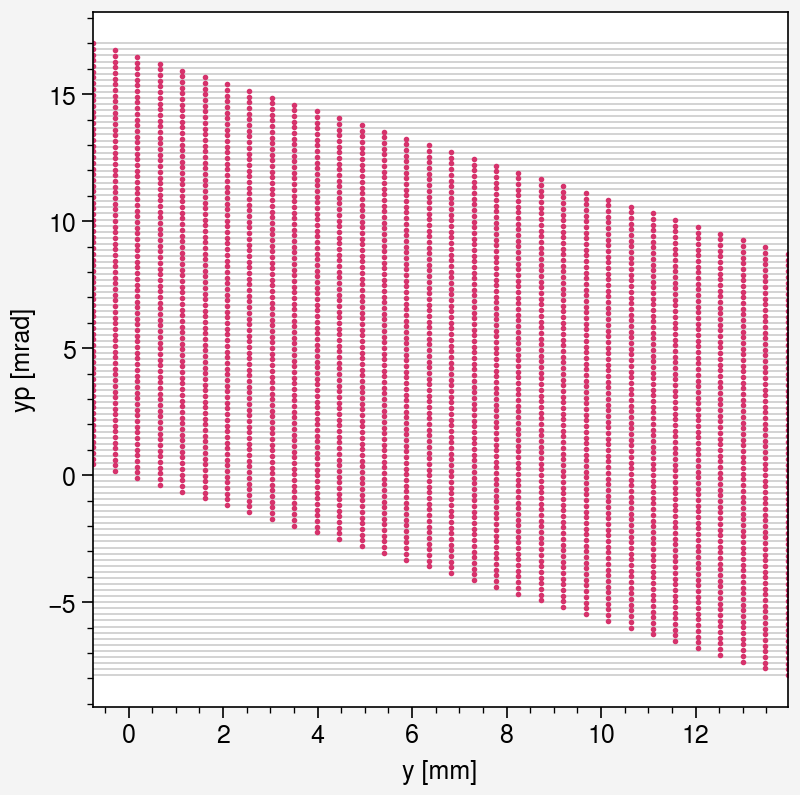

In [21]:
ypgrid_scale = 1.4  # scales resolution of y' interpolation grid
_Y, _Y3 = np.meshgrid(ygrid, y3grid, indexing='ij')
_YP = 1e3 * ecalc.calculate_yp(_Y * 1e-3, _Y3 * 1e-3, Mscreen)  # [mrad]
ypgrid = np.linspace(np.min(_YP), np.max(_YP), int(ypgrid_scale * image_shape[0]))

fig, ax = pplt.subplots(figwidth=4)
for yp in ypgrid:
    ax.axhline(yp, **line_kws)
ax.plot(_Y.ravel(), _YP.ravel(), color='pink7', lw=0, marker='.', ms=2)
ax.format(xlabel='y [mm]', ylabel='yp [mrad]')
plt.savefig('_output/yyp_interp_grid.png')
plt.show()

The $y$ coordinate is already on a grid. For each $\left\{x, x', y, x_3\right\}$, transform $y_3 \rightarrow y'$ and interpolate onto `ypgrid`. 

In [ ]:
shape = (len(xgrid), len(xpgrid), len(ygrid), len(ypgrid), image_shape[1])
f_new = np.zeros(shape)
for i in trange(shape[0]):
    for j in trange(shape[1]):
        for k in range(shape[2]):
            for m in range(shape[4]): 
                y = ygrid[k]
                yp = 1e3 * ecalc.calculate_yp(y * 1e-3, y3grid * 1e-3, Mscreen)
                fint = interpolate.interp1d(
                    yp,
                    f[i, j, k, :, m], 
                    kind='linear', 
                    fill_value=0.0, 
                    bounds_error=False,
                    assume_sorted=False,
                )
                f_new[i, j, k, :, m] = fint(ypgrid)
f = f_new.copy()

  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

### Interpolate energy spread $w$

Form the grid for the energy spread $w$.

In [ ]:
_W = np.zeros((shape[0], shape[1], image_shape[1]))
for i in range(shape[0]):
    for j in range(shape[1]):
        x = xgrid[i]
        xp = xpgrid[j]
        _W[i, j, :] = ecalc.calculate_dE_screen(x3grid * 1e-3, 0.0, x * 1e-3, xp * 1e-3, Mscreen)  # [MeV]
wgrid = np.linspace(np.min(_W), np.max(_W), image_shape[1])

Interpolate $w$ for each $\left\{x, x', y, y'\right\}$.

In [ ]:
savefilename = f'_output/f_{filename}.mmp'
f_new = np.memmap(savefilename, shape=shape, dtype='float', mode='w+') 
for i in trange(shape[0]):
    for j in trange(shape[1]):
        for k in range(shape[2]):
            for l in range(shape[3]):
                fint = interpolate.interp1d(
                    _W[i, j, :],
                    f[i, j, k, l, :],
                    kind='linear',
                    fill_value=0.0, 
                    bounds_error=False,
                    assume_sorted=False,
                )
                f_new[i, j, k, l, :] = fint(wgrid)

Save grid coordinates.

In [ ]:
coords = [xgrid, xpgrid, ygrid, ypgrid, wgrid]
for i in range(5):
    coords[i] = coords[i] - np.mean(coords[i])
utils.save_stacked_array(f'_output/coords_{filename}.npy', coords)